In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define class names
class_names = ["not fractured", "fractured"]

# Dataset preparation with COCO format and filtering
class CocoClassificationDataset(Dataset):
    def __init__(self, root, annFile, transform=None):
        self.root = root
        self.coco = datasets.CocoDetection(root=root, annFile=annFile)
        self.transform = transform
        self.missing_files = 0

    def __getitem__(self, idx):
        try:
            image, annotations = self.coco[idx]
            if self.transform:
                image = self.transform(image)
            # Set label based on category_id
            label = 1 if any(ann['category_id'] == 1 for ann in annotations) else 0
            return image, label
        except (FileNotFoundError, OSError):
            self.missing_files += 1
            return None

    def __len__(self):
        return len(self.coco)

# Path to data and annotation file
root_directory = r"C:\Users\lenovo\Downloads\Bone_New_Data\Bone_Fracture_Binary_Classification"
annotation_file = r"C:\Users\lenovo\Downloads\Bone_Fracture_Coco.json"

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load and filter dataset
dataset = CocoClassificationDataset(root=root_directory, annFile=annotation_file, transform=transform)
filtered_dataset = [item for item in dataset if item is not None]
print(f"Number of missing files: {dataset.missing_files}")

# Split dataset
train_size = int(0.8 * len(filtered_dataset))
val_size = len(filtered_dataset) - train_size
train_dataset, val_dataset = random_split(filtered_dataset, [train_size, val_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Define the model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping parameters
early_stop_patience = 3
best_val_loss = float('inf')
patience = 0

# Training function
num_epochs = 5  # Reduced for faster training

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience = 0
    else:
        patience += 1
        if patience >= early_stop_patience:
            print("Early stopping triggered")
            break


loading annotations into memory...
Done (t=0.20s)
creating index...
index created!


C:\Users\lenovo\.conda\envs\keras_env\lib\site-packages\PIL\Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Number of missing files: 18


C:\Users\lenovo\.conda\envs\keras_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\lenovo\.conda\envs\keras_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5], Loss: 0.2619, Val Loss: 0.1205
Epoch [2/5], Loss: 0.1091, Val Loss: 0.0555
Epoch [3/5], Loss: 0.0619, Val Loss: 0.0237
Epoch [4/5], Loss: 0.0569, Val Loss: 0.0696
Epoch [5/5], Loss: 0.0305, Val Loss: 0.0142


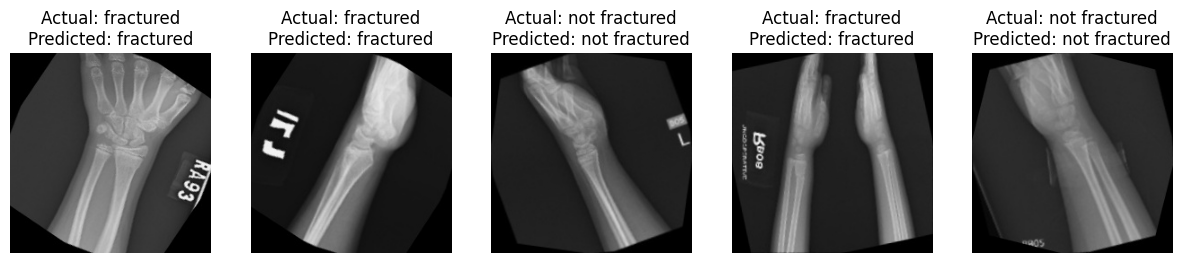

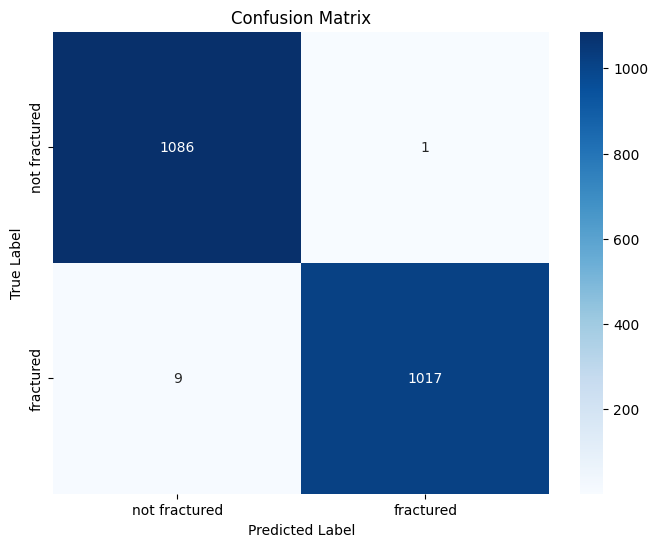

In [5]:

# Prediction visualization function
def visualize_predictions(model, data_loader, num_images=5):
    model.eval()
    images_shown = 0

    plt.figure(figsize=(15, 10))
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            for i in range(images.size(0)):
                if images_shown >= num_images:
                    break
                
                # Display image with actual and predicted labels
                image = images[i].cpu().permute(1, 2, 0).numpy()
                plt.subplot(1, num_images, images_shown + 1)
                plt.imshow(image)
                plt.title(f"Actual: {class_names[labels[i].item()]}\nPredicted: {class_names[preds[i].item()]}")
                plt.axis("off")
                images_shown += 1

            if images_shown >= num_images:
                break
    plt.show()

# Confusion matrix function
def plot_confusion_matrix(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Visualize sample predictions
visualize_predictions(model, val_loader, num_images=5)

# Plot confusion matrix
plot_confusion_matrix(model, val_loader)
